In [34]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import SGD
from scipy.integrate import quad, nquad

## Set hyperparameters

In [35]:
dim = 1
initilizer = RandomNormal(mean=0.0, stddev=1.0)

hidden_dim = 4 * dim
output_dim = 1

activation_func = "relu"

def create_model(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(units=hidden_dim, activation=activation_func, kernel_initializer=initilizer))
    model.add(Dense(units=hidden_dim, activation=activation_func, kernel_initializer=initilizer))
    model.add(Dense(units=hidden_dim, activation=activation_func, kernel_initializer=initilizer))
    model.add(Dense(units=output_dim, kernel_initializer=initilizer))

    return model

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000, decay_rate=0.9
)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

## Implement loss function

In [36]:
lam = 1.0  # Tbc
rho = 1.0  # Tbc

def f(x):
    return 1

def h_i(x, i):
    return x ** 2  # Tbc

def g(x):
    return x ** 2  # tbc

def mu_i_density(x, i):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)  # tbc

def sample_mu(n_samples, dim):
    return tf.random.normal((n_samples, dim))  # tbc

def beta_gamma():
    return 1

def cost_function(x, y):
    return x+y

def theta(x, y):
    return 1

## Create models

In [37]:
g_model = create_model(dim)
h_models = [create_model(1) for _ in range(dim)]

# g_model.compile(optimizer=opt, loss=CustomLoss())
# for model in h_models:
#     model.compile(optimizer=opt, loss=CustomLoss())

class CombinedModel(tf.keras.Model):
    def __init__(self, g_model, h_models):
        super(CombinedModel, self).__init__()
        self.g_model = g_model
        self.h_models = h_models

    def call(self, inputs):
        g_output = self.g_model(inputs)
        h_outputs = [h_model(inputs[:, i:i+1]) for i, h_model in enumerate(self.h_models)]
        return g_output, h_outputs

combined_model = CombinedModel(g_model, h_models)
combined_model.compile(optimizer='adam', loss=CustomLoss())

## Loss function

In [38]:
def phi_theta_gamma(samples):
    #h_integral = tf.reduce_sum(tf.map_fn(lambda i: tf.reduce_mean(h_i(samples[:, i], i)), tf.range(dim), dtype=tf.float32))
    h_integral = tf.reduce_sum([tf.reduce_mean(h_model(samples[:, i:i+1])) for i, h_model in enumerate(h_models)])
    #g_integral = tf.reduce_mean(tf.map_fn(g, samples, dtype=tf.float32))
    g_integral = tf.reduce_mean(g_model(samples))

    
    # y_values = tf.random.normal((10 ** 4, dim))  # TODO: Not explicit n_samples
    # theta_integral = tf.constant(0.0, dtype=tf.float32)
    # for x in samples:
    #     for y in y_values:
    #         integral_value += beta_gamma(f(y) - tf.reduce_sum([h_i(y, i) for i in tf.range(dim)]) - lam * cost_function(x, y) - g(x)) * theta(x, y)

    theta_integral = 0

    return lam * rho + h_integral + g_integral + theta_integral

class CustomLoss(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    
    def call(self, x_true, x_pred):
        #samples = sample_mu(tf.shape(x_pred)[0], dim)
        return phi_theta_gamma(x_pred)

In [39]:
n_samples = 10 ** 4
x_samples = sample_mu(n_samples, dim).numpy()
x_true_irrelevant = np.zeros_like(x_samples)

combined_model.fit(x_samples, x_true_irrelevant, epochs=5, batch_size=32)

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3043.9238
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 652.2734
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 237.1690
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 95.2513
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30.3263


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


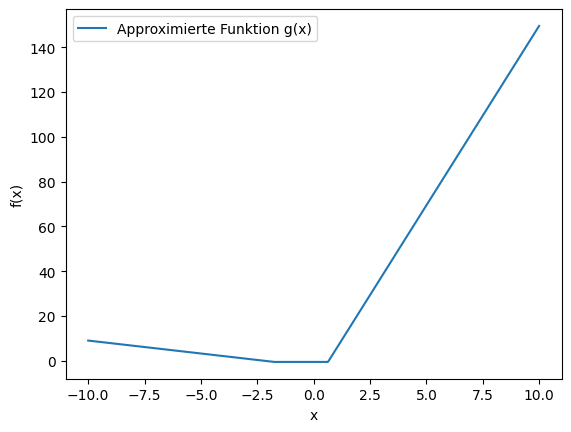

In [40]:
# Testdaten erstellen
x_test = tf.linspace(-10.0, 10.0, 500)
x_test = tf.reshape(x_test, (-1, dim))

# Vorhersagen mit dem kombinierten Modell
g_predictions, h_predictions = combined_model.predict(x_test)

# Für die Visualisierung nur g_predictions verwenden
plt.plot(x_test[:, 0], g_predictions, label='Approximierte Funktion g(x)')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()


# Not needed

In [41]:
""" import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad, nquad

# Beispiel für \rho
rho = 1.0  # Anpassen je nach Definition
lambda_val = 1.0

#Dummy-Beispiel für h_i und g. Muss später per NN optimiert werden (?).
def h_i(x, i):
    return x**2

def g(x):
    return sum(x)

# Beispiel für \beta_{\gamma} Funktion
def beta_gamma(z, gamma):
    # Dummy-Beispiel für die Funktion, anpassen je nach Definition
    return np.exp(-gamma * z**2)

# Dummy-Funktion für Verteilungen \bar{\mu}_i und \bar{\mu}
def mu_i_density(y, i):
    # Dummy-Dichtefunktion, anpassen je nach Definition
    return np.exp(-y**2 / 2) / np.sqrt(2 * np.pi)

def mu_density(x):
    # Dummy-Dichtefunktion, anpassen je nach Definition
    return np.exp(-np.sum(x**2) / 2) / (2 * np.pi)**(len(x)/2)

# Kostenfunktion c(x, y)
def cost_function(x, y):
    # Beispiel-Kostenfunktion, anpassen je nach Definition
    return np.linalg.norm(x - y)

# Funktion \phi_{\theta,\gamma}(f)
def phi_theta_gamma(f, theta, gamma, d):

    # Integrale berechnen
    h_integral = sum(quad(lambda y: h_i(y, i) * mu_i_density(y, i), -np.inf, np.inf)[0] for i in range(d))
    g_integral = nquad(lambda *x: g(x) * mu_density(np.array(x)), [(-np.inf, np.inf)] * d)[0]

    def integrand(x, y):
            return beta_gamma(f(y) - sum(h_i(y[0], i) for i in range(d)) - lambda_val * cost_function(x, y) - g, gamma) * theta(x, y)

    beta_integral = nquad(integrand, [(-np.inf, np.inf)] * (2*d))

    return lambda_val * rho + h_integral + g_integral + beta_integral


    # # Initiale Parameter
    # initial_params = np.zeros(d + 1 + d)
    
    # # Optimierung
    # result = minimize(objective, initial_params, method='SLSQP')
    
    # return result.fun


# Beispielaufruf der Funktion
if __name__ == "__main__":
    # Dummy \theta Funktion
    def theta(x, y):
        return 1.0  # Dummy-Wert, anpassen je nach Definition

    # Dummy f Funktion
    def f(y):
        return np.sum(y**2)  # Dummy-Wert, anpassen je nach Definition

    # Parameter
    gamma = 1.0
    d = 1  # Dimension

    # Funktionsaufruf
    result = phi_theta_gamma(f, theta, gamma, d)
    print(f'Result: {result}')
 """

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_63668/800979208.py:1: SyntaxWarning: invalid escape sequence '\g'
  """ import numpy as np


' import numpy as np\nfrom scipy.optimize import minimize\nfrom scipy.integrate import quad, nquad\n\n# Beispiel für \rho\nrho = 1.0  # Anpassen je nach Definition\nlambda_val = 1.0\n\n#Dummy-Beispiel für h_i und g. Muss später per NN optimiert werden (?).\ndef h_i(x, i):\n    return x**2\n\ndef g(x):\n    return sum(x)\n\n# Beispiel für \x08eta_{\\gamma} Funktion\ndef beta_gamma(z, gamma):\n    # Dummy-Beispiel für die Funktion, anpassen je nach Definition\n    return np.exp(-gamma * z**2)\n\n# Dummy-Funktion für Verteilungen \x08ar{\\mu}_i und \x08ar{\\mu}\ndef mu_i_density(y, i):\n    # Dummy-Dichtefunktion, anpassen je nach Definition\n    return np.exp(-y**2 / 2) / np.sqrt(2 * np.pi)\n\ndef mu_density(x):\n    # Dummy-Dichtefunktion, anpassen je nach Definition\n    return np.exp(-np.sum(x**2) / 2) / (2 * np.pi)**(len(x)/2)\n\n# Kostenfunktion c(x, y)\ndef cost_function(x, y):\n    # Beispiel-Kostenfunktion, anpassen je nach Definition\n    return np.linalg.norm(x - y)\n\n# Funkti

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1893   
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5909e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2781e-05 
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2870e-05 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0572e-05 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8835e-05 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3968e-05 
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0251e-05 
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5888e-06 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7330e-06 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0350e-06 
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0735e-06 
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6263e-06
Epoch 15/50
32/32 ━━━━━

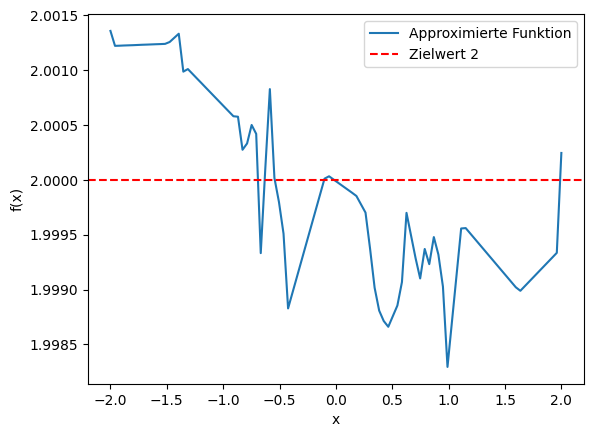

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Beispiel-Optimierungsproblem: Minimierung von (x - 2)^2
# Ziel ist es, eine Funktion f(x) zu approximieren, die dieses Problem minimiert.

# Erstellen Sie einige Beispiel-Daten (unüberwachtes Lernen)
x_train = np.random.rand(1000, 1) * 4 - 2  # Werte zwischen -2 und 2

# Definieren Sie die Struktur des neuronalen Netzes
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Definieren Sie die benutzerdefinierte Verlustfunktion
def custom_loss(y_true, y_pred):
    return tf.reduce_mean((y_pred - 2) ** 2)  # Beispiel: (f(x) - 2)^2

# Kompilieren Sie das Modell mit der benutzerdefinierten Verlustfunktion
model2.compile(optimizer=Adam(learning_rate=0.01), loss=custom_loss)

# Da es sich um unüberwachtes Lernen handelt, können wir Dummy-Zielwerte verwenden (werden nicht wirklich verwendet)
y_dummy = np.zeros_like(x_train)

# Trainieren Sie das Modell
model2.fit(x_train, y_dummy, epochs=50, batch_size=32)

# Testen Sie das Modell
x_test = np.linspace(-2, 2, 100).reshape(-1, 1)
y_pred = model2.predict(x_test)

import matplotlib.pyplot as plt

plt.plot(x_test, y_pred, label='Approximierte Funktion')
plt.axhline(2, color='r', linestyle='--', label='Zielwert 2')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()
